In [ ]:
#@title Default title text
%%capture
!pip install opendatasets
!pip install pandas
!pip install wordcloud
!pip install pandasql
!pip install ipyleaflet==0.16

In [ ]:
%%capture
import pandasql as ps

import math 

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pandas.plotting import scatter_matrix

%matplotlib inline

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
import statsmodels.formula.api as smf
import statsmodels.api as sm
import joblib

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OrdinalEncoder

from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
import numpy as np
from datetime import datetime

import folium
from folium.plugins import HeatMap
from folium import plugins

import wordcloud
from collections import Counter
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

In [ ]:
%%capture
import opendatasets as od
import pandas as pd
  
od.download(
    "https://www.kaggle.com/datasets/AnalyzeBoston/crimes-in-boston")

In [ ]:
%%shell
jupyter nbconvert --to html /content/crimes-in-boston/Boston_Crimes.ipynb
# /content/crimes-in-boston/Boston_Crimes.ipynb


[NbConvertApp] Converting notebook /content/crimes-in-boston/Boston_Crimes.ipynb to html
[NbConvertApp] Writing 7219455 bytes to /content/crimes-in-boston/Boston_Crimes.html


# **Part 1: ETL**

In [ ]:
# read the crime file
%%capture
crime = pd.read_csv('/content/crimes-in-boston/crime.csv', encoding='windows-1252')
crime.head()

In [ ]:
# read the offense_code file
%%capture
codes = pd.read_csv('/content/crimes-in-boston/offense_codes.csv', encoding='windows-1252')
codes.head()

In [ ]:
crime.shape

(319073, 17)

In [ ]:
# find the nulls
%%capture
crime.isnull().sum()

In [ ]:
# drop the 'shooting' column (too many nulls)
# then drop all other na rows

bos = crime.copy()
bos = crime.drop('SHOOTING', axis = 1)
bos.dropna(how = 'any', axis = 0, inplace = True)
bos.shape

(296573, 16)

In [ ]:
%%capture
bos.describe()

In [ ]:
%%capture
# print data type

print(bos.info())

In [ ]:
# change the day of week to str

bos['DAY_OF_WEEK']= bos['DAY_OF_WEEK'].astype(str)

In [ ]:
# extract month and day from 'OCCURRED_ON_DATE' column

bos['MONTH'] = pd.DatetimeIndex(bos['OCCURRED_ON_DATE']).month
bos['DAY'] = pd.DatetimeIndex(bos['OCCURRED_ON_DATE']).day

In [ ]:
%%capture
codes.shape

In [ ]:
%%capture
codes.isnull().sum()

In [ ]:
%%capture
codes.head()

In [ ]:
# SQL to link the crime code to description
%%capture
bos_crime_query = '''

SELECT *
FROM bos b
JOIN codes c 
ON b.OFFENSE_CODE = c.CODE

ORDER BY YEAR DESC
'''
boston = ps.sqldf(bos_crime_query, globals())
boston.head()

In [ ]:
%%capture
boston = boston.rename(columns={'NAME': 'OFFENSE_NAME'})
boston.columns

In [ ]:
%%capture
boston['OFFENSE_CODE_GROUP'].unique().tolist()

In [ ]:
# replace the spce with underscore

boston['OFFENSE_CODE_GROUP'].replace('\s+', '_',regex=True,inplace=True)
# boston['OFFENSE_CODE_GROUP'].unique().tolist()
# print(len(boston['OFFENSE_CODE_GROUP'].unique().tolist()))

In [ ]:
# correlation 
%%capture
bos_corr = boston.corr()
bos_corr

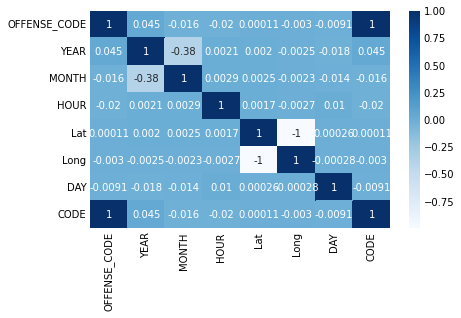

In [ ]:
# correlation heatmap - no significant correlations between the variables

sns.heatmap(bos_corr, cmap ="Blues", annot =True);

# **Part 2: Visualization**

In [ ]:
# boston crime heatmap (use 200000 crimes in the boston dataset)

lon = boston['Long']
lat = boston['Lat']

average_Lon = sum(lon)/len(lon)
average_Lat = sum(lat)/len(lat)

boston_location = boston[['OFFENSE_CODE_GROUP','Long', 'Lat']]
bost = boston_location.groupby(['OFFENSE_CODE_GROUP']).mean().reset_index()

# this part calls the folium.Map funcion, the bigger the zoom_start, the closer in 
crime_map = folium.Map(location=[average_Lat, average_Lon],
                      zoom_start = 11)

# add the crime data to the heat map
crime_heatmap = boston[-200000:]
crime_heatmap = crime_heatmap[['Lat','Long']]
data_heatmap = [[row['Lat'],row['Long']] for index, row in crime_heatmap.iterrows()]
HeatMap(crime_heatmap, radius = 12).add_to(crime_map)

folium.TileLayer('Stamen Terrain').add_to(crime_map)

crime_map

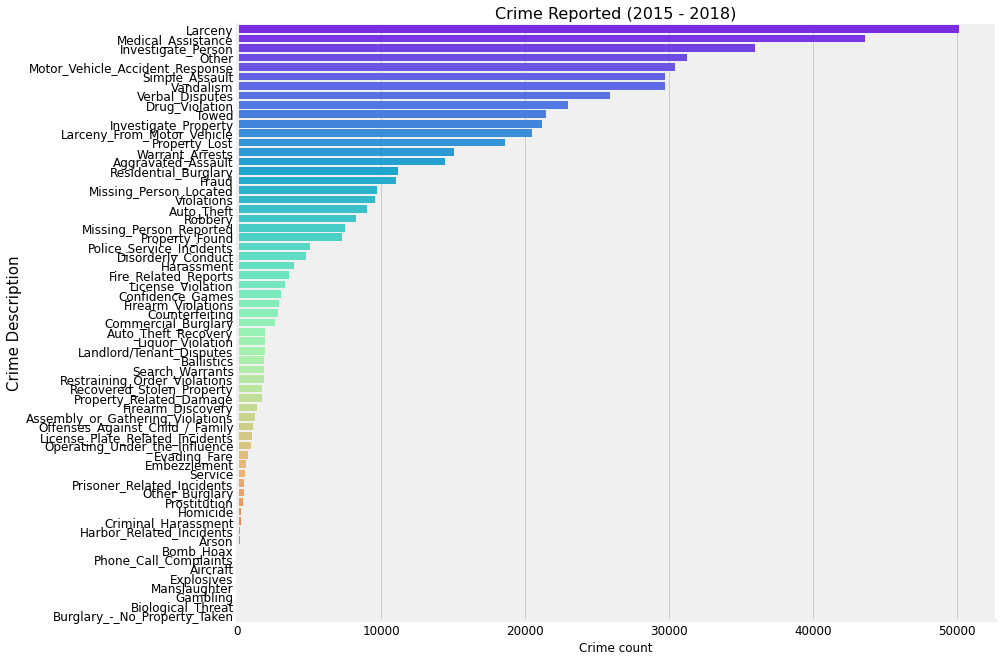

In [ ]:
# graph for offense description 

sns.catplot(y='OFFENSE_CODE_GROUP',
           kind ='count',
           height = 9,
           aspect = 1.5, 
           palette=("rainbow"),
           order=boston.OFFENSE_CODE_GROUP.value_counts().index,
           data=boston)

plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Crime count", fontsize = 12)
plt.ylabel("Crime Description", fontsize = 15)
plt.title("Crime Reported (2015 - 2018)", fontsize = 16);

In [ ]:
# remove some of the group code that are more neutral words (aircraft, servic, other etc)

boston_cloud_query = '''
SELECT * 
FROM boston

WHERE NOT "OFFENSE_CODE_GROUP" IN ("Aircraft", "Service", "Confidence_Games",
                                        "Towed", "Medical_Assistance", "Other")
'''

boston_cloud = ps.sqldf(boston_cloud_query, globals())

In [ ]:
# wordcloud for offense creported in the dataset
# from nltk.corpus import stopwords

%%capture
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))

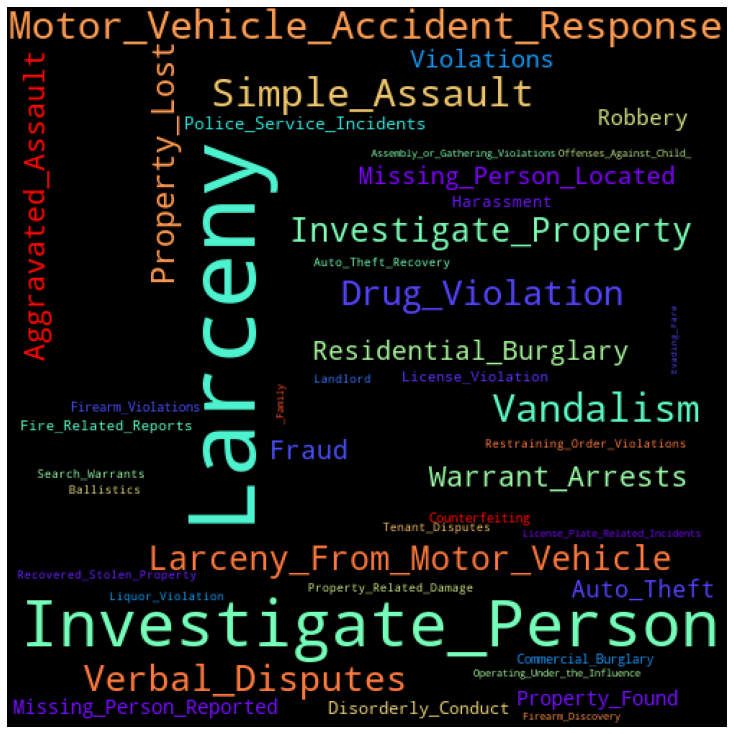

In [ ]:
# wordcloud of the crime description

from wordcloud import WordCloud

most_common = " ".join(i for i in boston_cloud['OFFENSE_CODE_GROUP'])

wordcloud = WordCloud(width = 500, height = 500, 
                      background_color = 'black',
                      stopwords = stop_words,
                      mask = None,  contour_color = 'blue',  
                      min_font_size = 6, collocations=False,
                      max_font_size = None, mode = 'RGB',
                      colormap = 'rainbow').generate(most_common)                                     


# plot word cloud
plt.figure(figsize = (15, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)

plt.show()

In [ ]:
# crime_2017 map by offense code group

crime_2017_query = '''

SELECT "Long", "Lat", "OFFENSE_CODE_GROUP", "CODE", 
"YEAR", "MONTH", "DAY", "HOUR", "DISTRICT"
FROM boston
WHERE "OFFENSE_CODE_GROUP" IN ("Homicide","Firearm_Violations", 
                               "Criminal_Harassment", "Aggravated_Assault",
                               "Arson")
AND "YEAR" = 2017

LIMIT 500

'''
crime_2017 = ps.sqldf(crime_2017_query, globals())
# crime_2017.head()
# crime_2017.shape

In [ ]:
# define colors of the offense_code_group 
%%capture
def select_marker_color(row):
    if row['OFFENSE_CODE_GROUP'] == 'Homicide':
        return 'red'
    elif row['OFFENSE_CODE_GROUP'] == 'Firearm_Violations':
        return 'green'
    elif row['OFFENSE_CODE_GROUP'] == 'Criminal_Harassment':
        return 'black'
    elif row['OFFENSE_CODE_GROUP'] == 'Arson':
        return 'orange'
    else: 
        return 'blue'

crime_2017['colors'] = crime_2017.apply(select_marker_color, axis = 1 )
crime_2017.head()

In [ ]:
%%capture
crime_2017['OFFENSE_CODE_GROUP'].value_counts()

In [ ]:
# major crimes in 2017 in Boston map
# interactive: the 'i' on the markers shows the police district where the crime committed

crime_2017_map = folium.Map(
    location = [42.347174,-71.096444], zoom_start = 2
)

for _, scene in crime_2017.iterrows():
    folium.Marker(
    location = [scene['Lat'], scene['Long']],
        popup = scene['DISTRICT'], 
        icon = folium.Icon(color = scene['colors'])
    ).add_to(crime_2017_map)
    
crime_2017_map

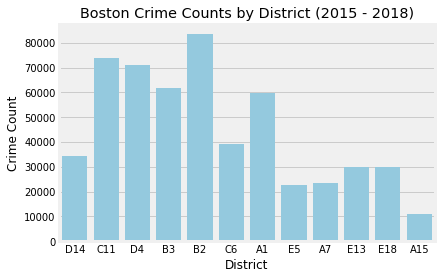

In [ ]:
# plot a graph of crimes by district 

boston_dis = boston.DISTRICT.tolist()

dist_bins = np.array(boston_dis)
sns.countplot(boston['DISTRICT'], color='skyblue')
plt.title("Boston Crime Counts by District (2015 - 2018)")
plt.xlabel("District")
plt.ylabel("Crime Count")
plt.show()

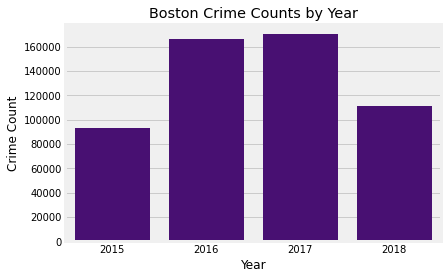

In [ ]:
# plot graph of crimes over the years

year_list = boston.YEAR.tolist()

dist_bins = np.array(year_list)
sns.countplot(boston['YEAR'], color='indigo')
plt.title("Boston Crime Counts by Year")
plt.xlabel("Year")
plt.ylabel("Crime Count")
plt.show()

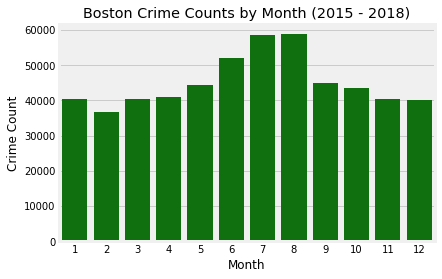

In [ ]:
# plot graph of the crime by month

boston_month = boston.MONTH.tolist()

dist_bins = np.array(boston_month)
sns.countplot(boston['MONTH'], color='green')
plt.title("Boston Crime Counts by Month (2015 - 2018)")
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.show()

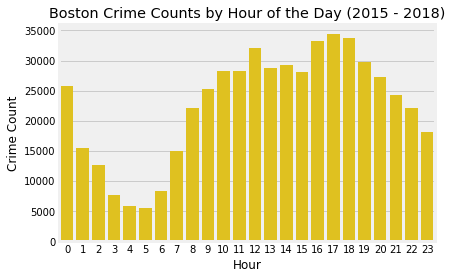

In [ ]:
boston_hour = boston.HOUR.tolist()

dist_bins = np.array(boston_hour)
sns.countplot(boston['HOUR'], color='gold')
plt.title("Boston Crime Counts by Hour of the Day (2015 - 2018)")
plt.xlabel("Hour")
plt.ylabel("Crime Count")
plt.show()